In [12]:
import matplotlib.pyplot as pp
import pycbc.noise
import pycbc.psd

In [13]:
# generate some colored gaussian noise
flow = 30.0
delta_f = 1.0 / 16
flen = int(16384 / delta_f) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

### Generate 128 seconds of noise at 4096 Hz
delta_t = 1.0 / 16384
tsamples = int(128 / delta_t)
ts = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=127)

# Estimate the PSD
# We'll choose 4 seconds PSD samples that are overlapped 50 %
seg_len = int(4 / delta_t)
seg_stride = int(seg_len / 2)
estimated_psd = pycbc.psd.welch(ts,
                      seg_len=seg_len,
                      seg_stride=seg_stride)

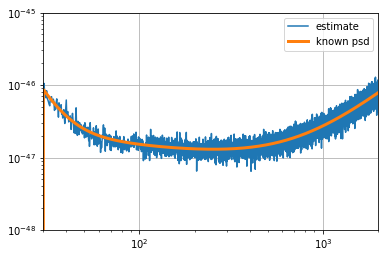

In [14]:
pp.loglog(estimated_psd.sample_frequencies, estimated_psd, label='estimate')
pp.loglog(psd.sample_frequencies, psd, linewidth=3, label='known psd')
pp.xlim(xmin=flow, xmax=2000)
pp.ylim(1e-48, 1e-45)
pp.legend()
pp.grid()
pp.show()

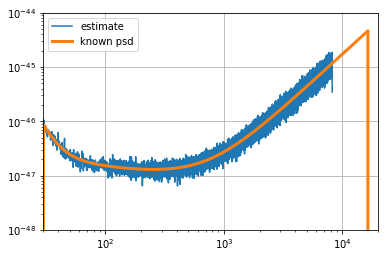

In [15]:
pp.loglog(estimated_psd.sample_frequencies, estimated_psd, label='estimate')
pp.loglog(psd.sample_frequencies, psd, linewidth=3, label='known psd')
pp.xlim(xmin=flow, xmax=20000)
pp.ylim(1e-48, 1e-44)
pp.legend()
pp.grid()
pp.show()

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import arviz as az
import h5py
import pandas as pd

import ringdown as rd

from pyRing import pyRing
from pyRing import likelihood
from pyRing import noise

from pycbc.inference import io, models
from pycbc.workflow import WorkflowConfigParser
from pycbc import detector
import lal

from tqdm import tqdm

/work/yifan.wang/virtualenv/ringdown/lib/python3.7/site-packages/pyRing/utils.py:16: UserWarning: surfinBH is not automatically installed due to possible conflicts. If you wish to use its functionalities, it needs to be installed separately.
  warnings.warn("surfinBH is not automatically installed due to possible conflicts. If you wish to use its functionalities, it needs to be installed separately.")


In [2]:
%matplotlib inline 
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]
params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}
mpl.rcParams.update(params)

In [3]:
fit = rd.Fit(model='mchi_aligned')

def read_strain(file, dname):
    with h5py.File(file, 'r') as f:
        t0 = f['meta/GPSstart'][()]
        T = f['meta/Duration'][()]
        h = f['strain/Strain'][:]
    
        dt = T/len(h)
    
        raw_strain = rd.Data(h, index=t0 + dt*np.arange(len(h)), ifo=dname)
        
        return raw_strain

ifos = ['H1', 'L1']
input_path = '/work/yifan.wang/ringdown/GW150914/maxisi-data-release/{i}-{i}1_GWOSC_16KHZ_R1-1126257415-4096.hdf5'
raw_strain = {i: read_strain(input_path.format(i=i[0]), i) for i in ifos}

for s in raw_strain.values():
    fit.add_data(s)
T = 0.2
srate = 4096
fit.set_target(1126259462.4083147, ra=1.95, dec=-1.27, psi=0.82, duration=T)

# condition data
fit.condition_data(ds=int(round(raw_strain[ifos[0]].fsamp/srate)), flow=20)

In [4]:
fit.compute_acfs()

In [5]:
#Ringdown start time
fit.start_times

{'H1': 1126259462.423, 'L1': 1126259462.4160156}

In [8]:
np.savetxt('./acf_ringdown_s4096_H1.txt',
           np.transpose([fit.acfs['H1'].index.values,fit.acfs['H1'].values]))

In [9]:
np.savetxt('./acf_ringdown_s4096_L1.txt',
           np.transpose([fit.acfs['L1'].index.values,fit.acfs['L1'].values]))

In [69]:
#PyRing start time
model.tevent

1126259462.423

In [70]:
#PyRing start time
model.time_delay

{'H1_H1': 0.0, 'H1_L1': -0.006984417432715555}

In [71]:
#PyRing start time
model.tevent + model.time_delay['H1_L1']

1126259462.4160156

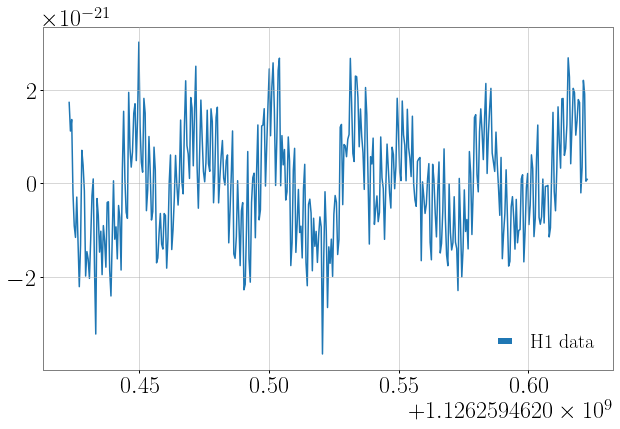

In [76]:
plt.plot(fit.analysis_data['H1'].index.values,fit.analysis_data['H1'].values,label='H1 data')
plt.legend(loc='best')

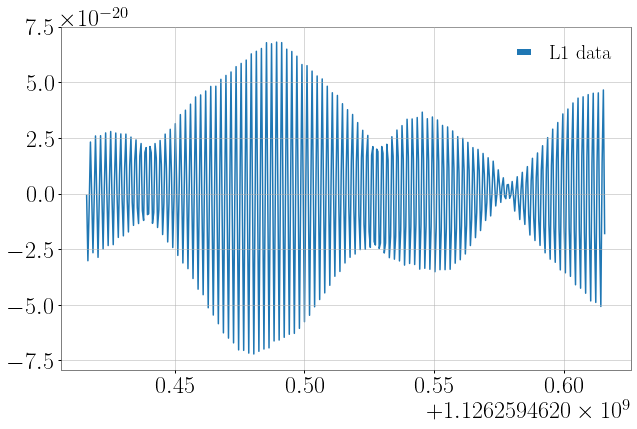

In [77]:
plt.plot(fit.analysis_data['L1'].index.values,fit.analysis_data['L1'].values,label='L1 data')
plt.legend(loc='best')

# Run Pyring

In [20]:
input_par = {'data-H1': '', 
             'data-L1': '', 
             'data-V1': '', 
             'ignore-data-filename': 0, 
             'download-data': 1, 
             'datalen-download': 4096.0, 
             'gw-data-find': 0, 
             'gw-data-type-H1': '', 
             'gw-data-type-L1': '', 
             'gw-data-type-V1': '', 
             'tag': 'CLN', 
             'channel-H1': 'GWOSC', 
             'channel-L1': 'GWOSC', 
             'channel-V1': 'GWOSC', 
             'config-file': 'config_gw150914_production.ini', 
             'run-type': 'full', 
             'output': 'GW150914_PROD1_Kerr_221_0M', 
             'run-tag': 'PROD1', 
             'screen-output': 0, 
             'pesummary': 1, 
             'trigtime': 1126259462.423, 
             'detectors': ['H1', 'L1'], 
             'ref-det': 'H1', 
             'sky-frame': 'equatorial', 
             'acf-H1': '', 
             'acf-L1': '', 
             'acf-V1': '', 
             'psd-H1': '', 
             'psd-L1': '', 
             'psd-V1': '', 
             'signal-chunksize': 4.0, 
             'noise-chunksize': 4.0, 
             'window-onsource': 0, 
             'window': 1, 
             'alpha-window': 0.1, 
             'sampling-rate': 2048, 
             'f-min-bp': 20.0, 
             'f-max-bp': 1014.0, 
             'bandpassing': 1, 
             'fft-acf': 1, 
             'acf-simple-norm': 1, 
             'no-lognorm': 0, 
             'truncate': 1, 
             'analysis-duration': 0.2, 
             'analysis-duration-n': int(0.2*2048),
             'zero-noise': 0, 
             'gaussian-noise': '', 
             'gaussian-noise-seed': -1, 
             'gaussian-noise-white-sigma': 1e-21, 
             'chisquare-computation': 0, 
             'non-stationarity-check': 0, 
             'onsource-ACF': 0, 
             'noise-averaging-method': 'mean', 
             'Dirac-comb': 0, 
             'Zeroing-data': 0, 
             'maxent-psd': '', 
             'PSD-investigation': 0, 
             'injection-parameters': None, 
             'injection-approximant': '', 
             'inject-n-ds-modes': {'t': 1}, 
             'inject-area-quantization': 0, 
             'inject-charge': 0, 
             'injection-scaling': 1.0, 
             'injection-T': 64.0, 
             'template': 'Kerr', 
             'single-mode': None, 
             'n-ds-modes': {'t': 1}, 
             'ds-ordering': 'freq', 
             'kerr-modes': [(2, 2, 2, 0), (2, 2, 2, 1)], 
             'reference-amplitude': 1e-21, 
             'spheroidal': 0, 
             'qnm-fit': 1, 
             'coherent-n': 0, 
             'amp-non-prec-sym': 1, 
             'max-Kerr-amp-ratio': 0.0, 
             'TGR-overtones-ordering': 'Unordered', 
             'domega-tgr-modes': None, 
             'dtau-tgr-modes': None, 
             'area-quantization': 0, 
             'tau-AQ': 0, 
             'prior-reweight': 0, 
             'ParSpec': 0, 
             'ParSpec_Dmax_TGR': 2, 
             'ParSpec_Dmax_charge': 0, 
             'EsGB': 0, 
             'charge': 0, 
             'gr-time-prior': 1, 
             'dist-flat-prior': 0, 
             'ds-amp-flat-prior': 0, 
             'mf-time-prior': 67.92493161247017, 
             'nonref-det': 'L1'}
model = pyRing.KerrModel(modes=input_par['kerr-modes'],**input_par)


Trigtime in H1: 1126259462.423000


Reading data...

Using GWPY to download data.
Fetched 1 URLs from www.gw-openscience.org for [1126257414 .. 1126261510))
Reading data... [Done]

Loaded channel GWOSC starting at 1126257414.0 length 4096.0s.
Bandpassing the raw strain between [20.0, 1014.0] Hz.
Downsampling detector data from 16384.0 to 2048 Hz, decimate factor 8
Computing the one-sided PSD with the Welch method and the standard ACF for comparison.
No ACF was passed. Estimating ACF.
Plancherel theorem E(f)/E(t) (expected value: 1) = 1.0658423205057252

Reading data...

Using GWPY to download data.
Fetched 1 URLs from www.gw-openscience.org for [1126257414 .. 1126261510))
Reading data... [Done]

Loaded channel GWOSC starting at 1126257414.0 length 4096.0s.
Bandpassing the raw strain between [20.0, 1014.0] Hz.
Downsampling detector data from 16384.0 to 2048 Hz, decimate factor 8
Computing the one-sided PSD with the Welch method and the standard ACF for comparison.
No ACF was passed. Es

In [43]:
pr_par = {'Mf': 71.23144804,
 'af': 0.70217625,
 'A2220': 7.455027339179161,
 'A2221': 7.7018212353194695,
 'phi2220': -0.8654620165770146,
 'phi2221': 1.7441770208736807}
model.log_likelihood(pr_par)

39342.91014056111

In [79]:
prdata = {}
prtime = {}
for d in model.detectors:
    dt   = model.time_delay['{0}_'.format(model.ref_det)+d]
    relative_time = model.detectors[d].time - (model.tevent+dt)
    logic = relative_time >= model.fixed_params['t']
    prtime[d] = relative_time[logic][:model.duration_n] + (model.tevent+dt)
    prdata[d] = model.detectors[d].time_series[logic][:model.duration_n]

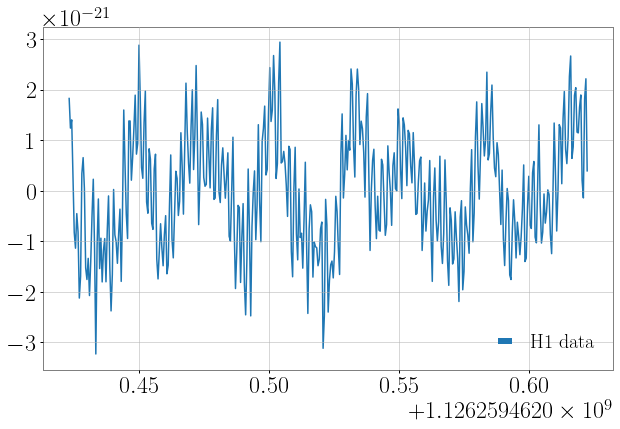

In [80]:
plt.plot(prtime['H1'],prdata['H1'],label='H1 data')
plt.legend(loc='best')

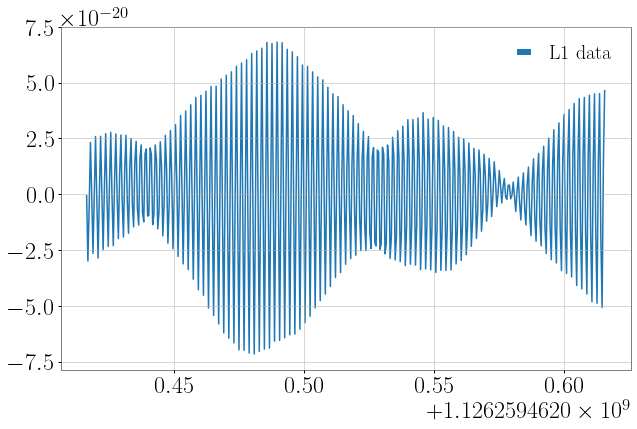

In [81]:
plt.plot(prtime['L1'],prdata['L1'],label='L1 data')
plt.legend(loc='best')

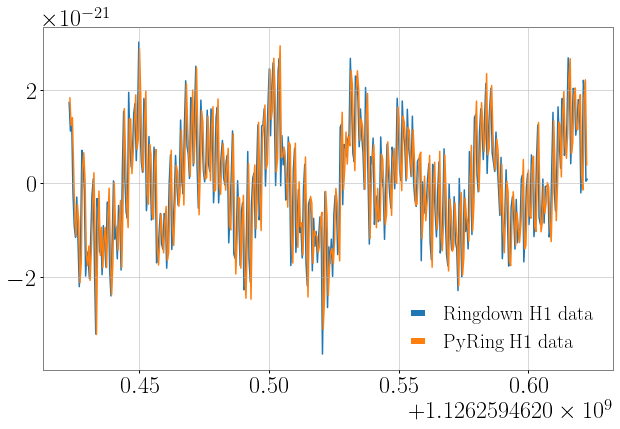

In [82]:
plt.plot(fit.analysis_data['H1'].index.values,fit.analysis_data['H1'].values,label='Ringdown H1 data')
plt.plot(prtime['H1'],prdata['H1'],label='PyRing H1 data')
plt.legend(loc='best')

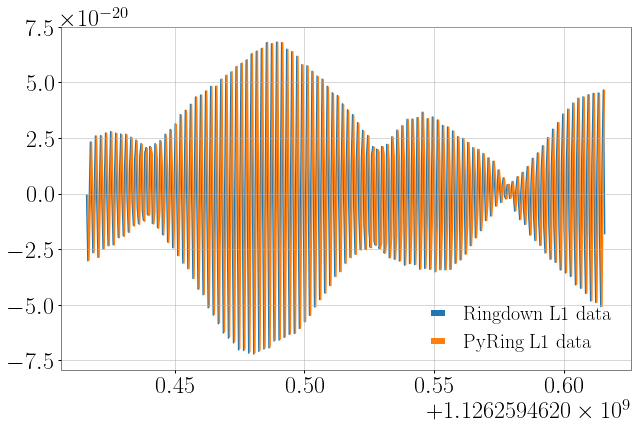

In [83]:
plt.plot(fit.analysis_data['L1'].index.values,fit.analysis_data['L1'].values,label='Ringdown L1 data')
plt.plot(prtime['L1'],prdata['L1'],label='PyRing L1 data')
plt.legend(loc='best')